In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import tensorflow as tf 

%matplotlib inline

# 1. Create Data for Toy Problem

In [2]:
def sin(x, T=100):
    return np.sin(2.0 * np.pi * x/T)

def toy_problem(T=100, ampl=0.05):
    x = np.arange(0, 2*T + 1)
    noise = ampl*np.random.uniform(low = -1.0, high = 1.0, size=len(x))
    return sin(x) + noise

T = 150
f = toy_problem(T)
plt.plot(f)
#f[0::10] = f[0::10] + 0.3
f[0::10] = f[0::10] + 0.3
plt.plot(f)
print('Assume that at every 10th element there is a little extra added to the series')
print('Question: Can an RNN fit this?')

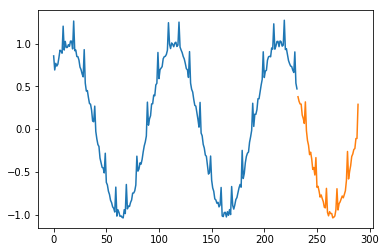

In [3]:
from scipy.linalg import hankel
# hankel matrix takes 'first colum' and 'last row' as arguments
wx = 10
#maxlen = 25
maxlen = 5
first_column = list(range(wx))
last_row = list(range(wx, f.shape[0]-1, 1))
t_pos = hankel(first_column, last_row)
X = f[t_pos]
Y = f[t_pos[-1,:]+1]

# Now arrange as a training and test set
N_train = int(X.shape[1]*0.8)
(X_train, Y_train) = (X[:, :N_train], Y[:N_train])
(X_test, Y_test)   = (X[:, (N_train - maxlen):], Y[N_train:])
plt.plot(Y_train)
plt.plot(list(range(Y.shape[0])[N_train:]), Y_test)

# Define Graph

In [4]:
n_in = 1
n_hidden = 20
n_out = 1
#maxlen = 25

tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape=[wx, maxlen])
ybar = tf.placeholder(tf.float32, shape=[maxlen])
h0   = tf.placeholder(tf.float32, shape=[n_hidden])
#h_prev = tf.zeros([n_hidden], dtype=tf.float32)
h_prev = h0

# TF Variables
#y = inference(x, n_batch, maxlen=maxlen, n_hidden=n_hidden, n_out= n_out)
#loss = loss(y, t)
#train_step = training(loss)

# h_t = f(U x_t + W h_{t-1} + b)
# y_t = V h_t + c

V = tf.Variable(tf.truncated_normal([n_hidden], stddev=0.01), name="V")
c = tf.Variable(tf.zeros([n_out], dtype=tf.float32), name="c")
U = tf.Variable(tf.truncated_normal([n_hidden, wx], stddev=0.01), name="U")
W = tf.Variable(tf.truncated_normal([n_hidden, n_hidden], stddev=0.01), name="W")
b = tf.Variable(tf.zeros([n_hidden], dtype=tf.float32), name="b")

hlist = []

for i in range(maxlen):
    h_i = tf.tanh(tf.reduce_sum(U*x[:, i], axis=1) + 
                  tf.reduce_sum(W*h_prev, axis=1) + b)
    hlist.append(h_i)
    h_prev = hlist[-1]
y = tf.convert_to_tensor([tf.reduce_sum(V*h) + c for h in hlist], 
                         dtype=tf.float32)
h1ops = hlist[1]
mse = tf.reduce_mean(tf.square(y[-1] - ybar[-1]))
#mse = tf.reduce_mean(tf.square(y - ybar))

optimize = tf.train.GradientDescentOptimizer(learning_rate = 0.001)
train_step = optimize.minimize(mse)
#grads_and_vars = optimize.compute_gradients(mse, tf.trainable_variables())
grads_and_vars = optimize.compute_gradients(tf.square(y - ybar), tf.trainable_variables())

In [5]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

# Train Model

In [6]:
epochs = 100
h1 = np.zeros(n_hidden)

for epoch in range(epochs):
    mselist = []
    for i in range(X_train.shape[1] - maxlen):
        train_dict = {x: X_train[:,i:(maxlen + i)],
                      ybar: Y_train[i:(maxlen + i)],
                      h0: h1}
        _, h1 = sess.run([train_step, h1ops], feed_dict = train_dict)
        mselist.append(mse.eval(session=sess, feed_dict = train_dict))
    print(np.mean(mselist))      

0.536709
0.510867
0.44671
0.301283
0.143607
0.0778606
0.0629481
0.0583428
0.0555927
0.0533603
0.0513436
0.049446
0.0476296
0.0458772
0.0441803
0.0425339
0.0409351
0.0393826
0.0378756
0.0364142
0.0349988
0.0336304
0.03231
0.0310391
0.0298191
0.0286516
0.027538
0.0264797
0.025478
0.0245336
0.0236472
0.0228191
0.0220491
0.0213365
0.0206804
0.0200793
0.0195313
0.0190342
0.0185855
0.0181825
0.0178221
0.0175013
0.0172169
0.0169658
0.0167448
0.016551
0.0163814
0.0162334
0.0161044
0.0159921
0.0158944
0.0158094
0.0157353
0.0156706
0.015614
0.0155643
0.0155204
0.0154816
0.0154469
0.0154158
0.0153877
0.0153622
0.0153387
0.0153171
0.0152969
0.015278
0.0152601
0.0152431
0.0152269
0.0152113
0.0151962
0.0151816
0.0151673
0.0151534
0.0151398
0.0151264
0.0151132
0.0151002
0.0150874
0.0150747
0.0150621
0.0150497
0.0150374
0.0150251
0.015013
0.0150009
0.0149889
0.014977
0.0149652
0.0149534
0.0149417
0.01493
0.0149184
0.0149069
0.0148954
0.014884
0.0148726
0.0148613
0.01485
0.0148388


# Plot results - insample

In [ ]:
y_ = []
h1 = np.zeros(n_hidden)
for i in range(X_train.shape[1] - maxlen):
    train_dict = {x: X_train[:,i:(maxlen + i)],
                  h0: h1}
    yi_, h1 = sess.run([y, h1ops], feed_dict = train_dict)
    y_.append(yi_)
y_ = np.concatenate([x[-1] for x in y_])

In [ ]:

#original = [f[i + maxlen]  for i in range(X_train.shape[0])]
original = Y_train[maxlen:]
plt.rc('font', family='serif')
plt.figure()
mse_train = np.mean(np.square(y_ - original))
#plt.plot(toy_problem(T, ampl=0), linestyle='dotted', color='#aaaaaa')
plt.plot(original, linestyle='dashed', color='black')
plt.plot(y_, color='red')
plt.text(20, 0.6, r'maxlen = ' + str(maxlen) + '\n' +\
               r'wx = ' + str(wx) + '\n' +\
               r'epochs = ' + str(epochs) + '\n' +\
               r'ybar = full' + '\n' + 
               r'mse = ' + "{0:.5f}".format(np.mean(mse_train))
               , fontsize=10)
plt.title('Fit - Training Set')
print()

# Plot results - out of sample

In [ ]:
y_ = [y.eval(session=sess, feed_dict=
             {x: X_test[:,i:(maxlen + i)]})[-1]
      for i in range(X_test.shape[1] - maxlen)]
y_ = np.concatenate(y_)
#original = Y_test[maxlen:]
original = Y_test
plt.rc('font', family='serif')
plt.figure()
#plt.plot(toy_problem(T, ampl=0), linestyle='dotted', color='#aaaaaa')
plt.plot(original, linestyle='dashed', color='black')
plt.plot(y_, color='red')
plt.ylim(-1.2, 1.2)
plt.title('Fit test set')
mse_test = np.mean(np.square(y_ - original))
plt.text(20, 0.6, r'mse(test) = ' + "{0:.5f}".format(mse_test), fontsize=10)

In [ ]:
curve_range = np.array(range(30, 55, 1))
y_ = np.concatenate([y.eval(session=sess, feed_dict=
             {x: X_train[:,i:(maxlen + i)]})[-1]
      for i in curve_range])

yfull_ = [y.eval(session=sess, feed_dict=
             {x: X_train[:,i:(maxlen + i)]})
      for i in curve_range]
y_trail = np.concatenate(yfull_[-1])
plt.plot(Y_train[curve_range + maxlen], linestyle='dashed', color='black')
plt.plot(y_, color='red')
plt.plot(y_trail, color='lightblue', linestyle='dotted')


In [ ]:
yfull_ = [y.eval(session=sess, feed_dict=
             {x: X_train[:,i:(maxlen + i)]})
      for i in curve_range]

In [ ]:
np.concatenate(yfull_[10])

# Inspect gradients of W at the highpoint

In [ ]:
results = sess.run(grads_and_vars, feed_dict = {x: X_train[:,10:(maxlen + 10)], 
                                          ybar: Y_train[10:(maxlen + 10)]})
W_grads_and_vars = results[2]

In [ ]:
W_grads_and_vars[0].shape

In [ ]:
np.max(W_grads_and_vars[1])

In [ ]:
plt.matshow(W_grads_and_vars[1])

fig, ax = plt.subplots()
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
data = W_grads_and_vars[1]
ax.matshow(data, cmap='seismic')

for (i, j), z in np.ndenumerate(data*100):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

plt.show()

In [ ]:
tf.trainable_variables()

In [ ]:
truncate = maxlen
Z = X[:1]
original = [f[i] for i in range(maxlen)]
predicted = [None for i in range(maxlen)]

for i in range(length_of_sequences -maxlen +1):
    z_ = Z[-1:]
    y_ = y.eval(session=sess, feed_dict ={x: Z[-1:],
                                          n_batch: 1})
    sequence_ = np.concatenate((z_.reshape(maxlen, n_in)[1:], y_), axis=0)\
                               .reshape(1, maxlen, n_in)
    Z = np.append(Z, sequence_, axis=0)
    predicted.append(y_.reshape(-1))

plt.rc('font', family='serif')
plt.figure()
plt.plot(toy_problem(T, ampl=0), linestyle='dotted', color='#aaaaaa')
plt.plot(original, linestyle='dashed', color='black')
plt.plot(predicted, color='black')
plt.show()

In [ ]:
sess.run(train_step, feed_dict={
    x: X_[start:end],
    t: Y_[start:end],
    n_batch: N_train
    })
val_loss = loss.eval(session=sess, feed_dict={
    x: X_validation,
    t: Y_validation,
    n_batch: N_validation

In [ ]:
loss.eval(session=sess, feed_dict={
        x: X_validation,
        t: Y_validation,
        n_batch: N_validation
    })

# 3. Define Functions for Model

In [ ]:
def inference(x, n_batch, maxlen=None, n_hidden=None, n_out=None):
    def weight_variable(shape):
        initial = tf.truncated_normal(shape, stddev=0.01) # resample 2 sd vals
        return tf.Variable(initial)
    
    def bias_variable(shape):
        initial = tf.zeros(shape, dtype=tf.float32)
        return tf.Variable(initial)
    
    cell = tf.contrib.rnn.BasicRNNCell(n_hidden)
    initial_state = cell.zero_state(n_batch, tf.float32)
    
    state = initial_state
    outputs = []
    with tf.variable_scope('RNN'):
        for t in range(maxlen):
            if t > 0:
                tf.get_variable_scope().reuse_variables()
            (cell_output, state) = cell(x[:, t, :], state)
            outputs.append(cell_output)
    output = outputs[-1]
    
    V = weight_variable([n_hidden, n_out])
    c = bias_variable([n_out])
    y = tf.matmul(output, V) + c
    
    return y

def loss(y, t):
    mse = tf.reduce_mean(tf.square(y - t))
    return mse

def training(loss):
    optimize = tf.train.AdamOptimizer(learning_rate = 0.001, beta1=0.9, beta2=0.999)
    train_step = optimize.minimize(loss)
    return train_step

# 4. Define TF Graph

In [ ]:
n_in = len(X[0][0])
n_hidden = 20
n_out = len(Y[0])

tf.reset_default_graph()
# Input Parameters
x = tf.placeholder(tf.float32, shape=[None, maxlen, n_in])
t = tf.placeholder(tf.float32, shape=[None, n_out])
n_batch = tf.placeholder(tf.int32, [])

# TF Variables
y = inference(x, n_batch, maxlen=maxlen, n_hidden=n_hidden, n_out= n_out)
loss = loss(y, t)
train_step = training(loss)

# 5. Run Computational Graph (with batches)

In [ ]:
epochs = 500
batch_size = 10

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
history= {'val_loss': []}
n_batches = N_train // batch_size
early_stopping = ut.EarlyStopping(patience=100, verbose=1)
for epoch in range(epochs):
    X_, Y_ = shuffle(X_train, Y_train)
    
    for i in range(n_batches):
        start = i*batch_size
        end = start + batch_size
        
        sess.run(train_step, feed_dict={
            x: X_[start:end],
            t: Y_[start:end],
            n_batch: batch_size
        })
    val_loss = loss.eval(session=sess, feed_dict={
        x: X_validation,
        t: Y_validation,
        n_batch: N_validation
    })
    history['val_loss'].append(val_loss)
    print('epoch:', epoch, ' validation loss: ', val_loss)
    #Early Stopping
    if early_stopping.validate(val_loss):
        break

# Computational Graph without Batches

In [ ]:
epochs = 500
batch_size = 10

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
history= {'val_loss': []}
n_batches = N_train // batch_size
early_stopping = ut.EarlyStopping(patience=100, verbose=1)
for epoch in range(epochs):
    X_, Y_ = shuffle(X_train, Y_train)
    sess.run(train_step, feed_dict={
        x: X_[start:end],
        t: Y_[start:end],
        n_batch: N_train
        })
    val_loss = loss.eval(session=sess, feed_dict={
        x: X_validation,
        t: Y_validation,
        n_batch: N_validation
    })
    history['val_loss'].append(val_loss)
    print('epoch:', epoch, ' validation loss: ', val_loss)
    #Early Stoapping
    if early_bstopping.validate(val_loss):
        break

In [ ]:
truncate = maxlen
Z = X[:1]
original = [f[i] for i in range(maxlen)]
predicted = [None for i in range(maxlen)]

for i in range(length_of_sequences -maxlen +1):
    z_ = Z[-1:]
    y_ = y.eval(session=sess, feed_dict ={x: Z[-1:],
                                          n_batch: 1})
    sequence_ = np.concatenate((z_.reshape(maxlen, n_in)[1:], y_), axis=0)\
                               .reshape(1, maxlen, n_in)
    Z = np.append(Z, sequence_, axis=0)
    predicted.append(y_.reshape(-1))

plt.rc('font', family='serif')
plt.figure()
plt.plot(toy_problem(T, ampl=0), linestyle='dotted', color='#aaaaaa')
plt.plot(original, linestyle='dashed', color='black')
plt.plot(predicted, color='black')
plt.show()

In [ ]:
cell = tf.contrib.rnn.BasicRNNCell(n_hidden)
init_state = cell.zero_state(10, tf.float32)
state=init_state
outputs=[]
x=tf.placeholder(tf.float32, shape=[None, 2, 1])


In [ ]:
(cell_output, state) = cell(x[:, 0, :], state)

In [ ]:
X.shape

In [ ]:
with tf.variable_scope('RNN'):
    for t in range(maxlen):
        

In [ ]:
# For simplicty reasons, let us first implement a function that only has 2 lags
U = weight_variable([1, 1])
W = weight_variable([1, ])

h2 = tf.tanh(U)
V = weight_variable([n_hidden, 1])
c = bias_variable(1)
y = tf.matmul(h2, V) + c